open X:/Phagocytosis/sRBC/20190614cs1/track_4/test/Cell_CamB_ch0_stack0040_488nm_0301192msec_0003988839msecAbs_decon.tif;
open X:/Phagocytosis/sRBC/20190614cs1/track_4/test/Cell_CamA_ch1_stack0040_560nm_0301192msec_0003988839msecAbs_decon.tif;

material dull;

lighting full depthCue false;

windowsize 800 800;

volume #2 color #ffd059 level 158.7 step 2 region 46,55,0,143,130,228;

volume #1 color #2b5884 level 90 step 2;

surface dust #1,2 metric "volume rank" size 1;

volume #1,2 voxelSize 0.1028;

view matrix camera 0.54512,0.46357,-0.69853,-26.17,-0.8311,0.40824,-0.37765,-10.874,0.1101,0.78641,0.60781,36.433;
view name test;

measure convexity #1 palette brbg range 0.3,.5 smoothingIterations 20;

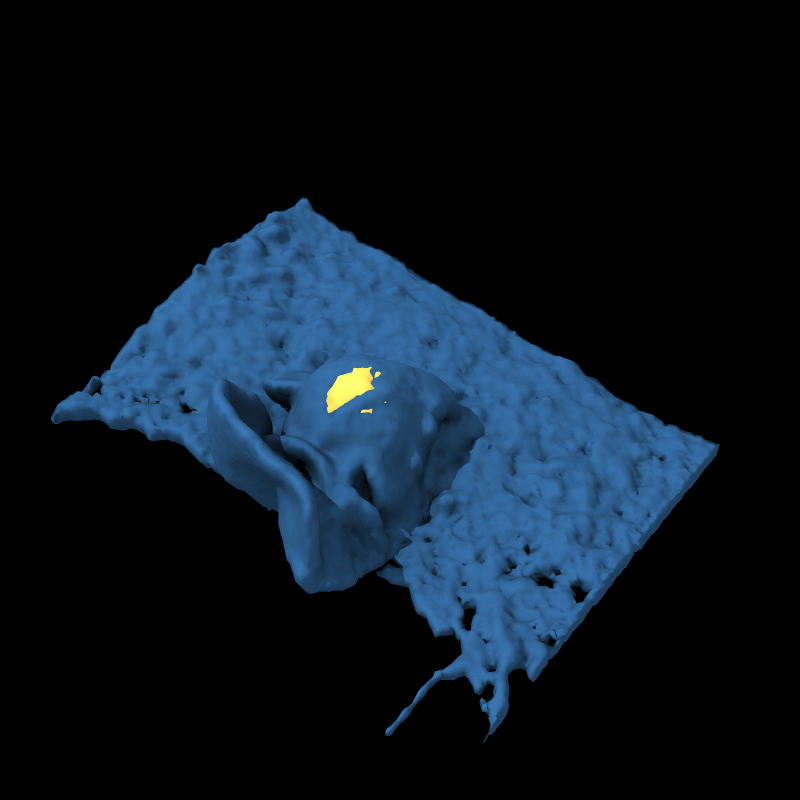 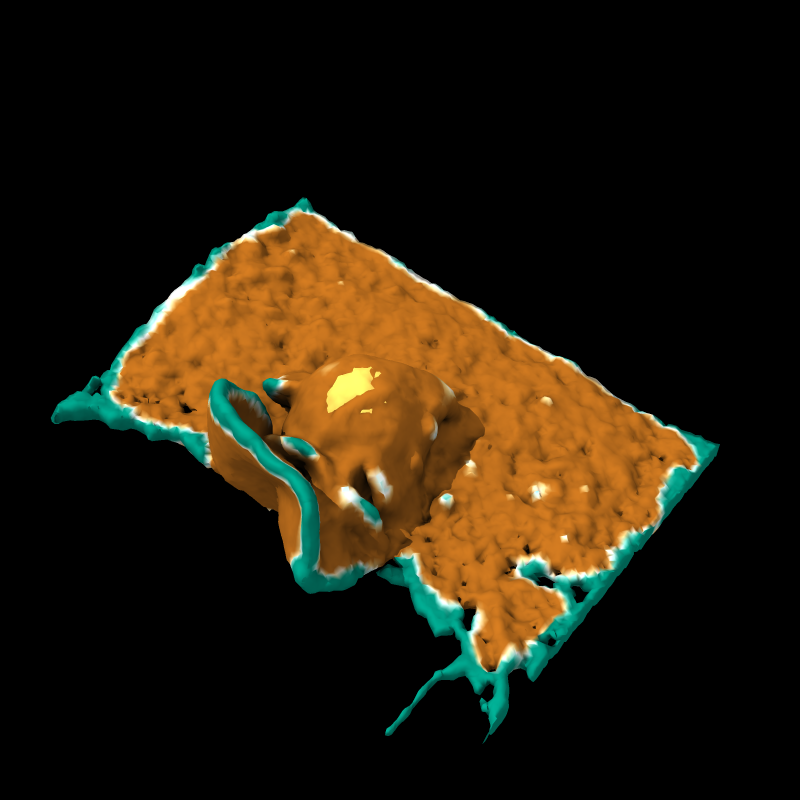

In [ ]:
from chimerax.color_key import show_key
from chimerax.core import colors
from chimerax.std_commands.wait import wait
from chimerax.core.commands import (BoolArg, Bounded, CmdDesc, ColormapArg,
                                    ColormapRangeArg, Int2Arg, IntArg,
                                    SurfacesArg, StringArg)
from chimerax.core.commands.cli import EnumOf
from chimerax.map.volumecommand import volume
from chimerax.std_commands.cd import (cd)
from os.path import exists
from numpy import (arccos, array, full, inf, isnan, mean, nan, nanmax, nanmean,
                   nanmin, pi, ravel_multi_index, sign, split, sqrt, subtract,
                   count_nonzero, swapaxes, savetxt, column_stack,nansum, nanstd,
                   unique, column_stack, round_, int64, abs, digitize, linspace,
                   zeros, where, delete)
from scipy.ndimage import (binary_dilation, binary_erosion,
                           generate_binary_structure, iterate_structure, gaussian_filter)
from scipy.spatial import KDTree
import numpy
import scipy
import matplotlib.pyplot as plt

In [ ]:
metric='RPD'
target ='sRBC'
size=(.1028,.1028,.1028)
palette=None
color_range= None
key=False
volume(session, voxel_size= size)
s= session
m= s.models
radius = 8
target_r = 2
centroid = mean(m[3].vertices, axis = 0)

x_coord, y_coord, z_coord = split(subtract(centroid, m[1].vertices), 3, 1)

z_squared = z_coord ** 2
y_squared = y_coord ** 2
x_squared = x_coord ** 2

distance = sqrt(z_squared + y_squared + x_squared)

distxy = sqrt(x_squared + y_squared)

""
theta = sign(y_coord)*arccos(x_coord / distxy)

phi = arccos(z_coord / distance)

"""Logic to identify vertices in the targets local (defined by radius input) around target's upper hemisphere"""
abovePhi = phi >= (pi/2)

radialClose = (distance  < radius) & (distance > target_r)

con = m[1].convexity
edgeind = (con>.3)
palette = None
color_range = 'full'
measurement = edgeind+0
palette_string = 'purples'
max_range = 15

if isnan(measurement).all():
    measurement[:] = 0


In [ ]:
if palette is None:
    palette = colors.BuiltinColormaps[palette_string]

if color_range is not None and color_range != 'full':
    rmin, rmax = color_range
elif color_range == 'full':
    rmin, rmax = nanmin(measurement), nanmax(measurement)
else:
    rmin, rmax = (0, max_range)

In [ ]:
cmap = palette.rescale_range(rmin, rmax)
m[1].vertex_colors = cmap.interpolated_rgba8(measurement[:,0])

Using the native chimeraX function we can identify high curvature edges of lamella in FLMs

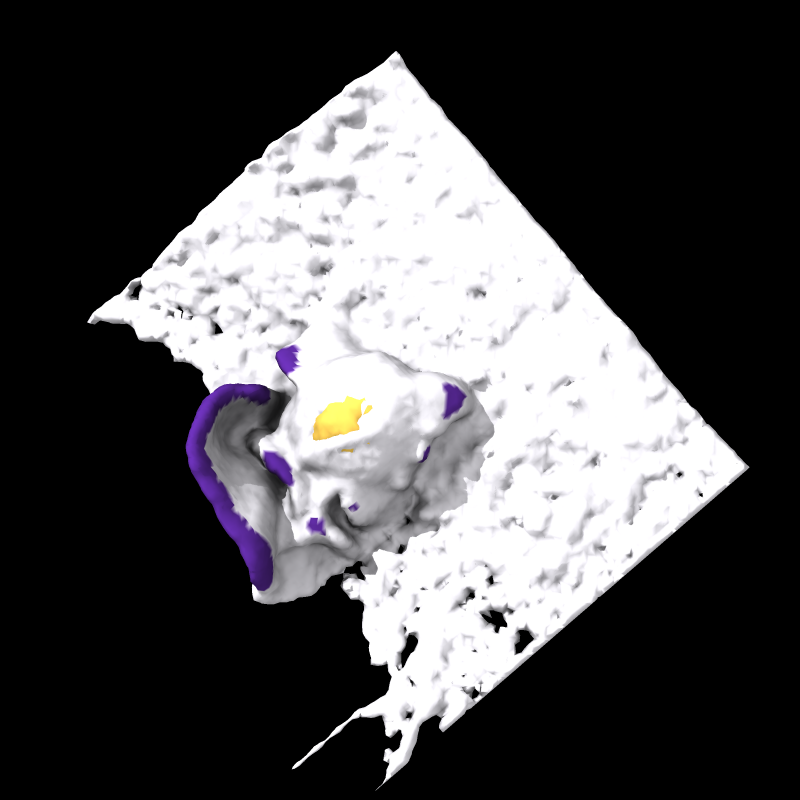

Image is paletted such that the purple regions are regions in the upper hemisphere search of 8 um.

Result: This shows promise as a parameter we can use to isolate large edges. Smaller edges of the lamella are not being identified well but specific segmenta are seen decently well. To take this a step further we want to track these lamella edges in time. proposed attempt will be to use a query tree approach to find where the membrane is growing to.

20230703:
Previously we used the high cuvature regions foudn with chimerax's curvature function to select most lamella ridges. Here I'm attempting to link the ridges in time on two sequential frames.

In [ ]:
t1 = m[1].convexity
t2 = m[3].convexity

ind1 = (t1>0.3)
ind2 = (t2>0.3)

car1=numpy.zeros(numpy.shape(m[1].vertices))
car2=numpy.zeros(numpy.shape(m[3].vertices))

car1[:,0]= m[1].vertices[:,0]*ind1
car1[:,1]= m[1].vertices[:,1]*ind1
car1[:,2]= m[1].vertices[:,2]*ind1

car2[:,0]= m[3].vertices[:,0]*ind2
car2[:,1]= m[3].vertices[:,1]*ind2
car2[:,2]= m[3].vertices[:,2]*ind2

car1[car1==0]=numpy.nan
car2[car2==0]=numpy.nan

Next we define the querry trees that BLS developed using the scipy KDtree module

In [ ]:
def query_tree(init_verts, to_map, radius=inf, knn=200):
    """Create a KDtree from a set of points and query for nearest neighbors.
    index: index of nearest neighbors within radius
    distance: Mean distance of nearest neighbors"""
    tree = KDTree(to_map)
    dist, index = tree.query(init_verts, k=range(
        1, knn), distance_upper_bound=radius, workers=-1)
    dist[dist == inf] = None
    distance = nanmean(dist, axis=1)
    index = array([_index(ind, tree.n) for ind in index], dtype=object)
    return distance, index

def _index(index, tree_max):
    """Tree query pads with tree_max if there are no neighbors."""
    index = index[index < tree_max]
    return index

In [ ]:
query_distance,_=query_tree(car1,car2,knn=200)

m[1].q_dist=query_distance

palette=None
color_range='full'
measurement = m[1].q_dist
palette_string = 'greens'
max_range = 10

# If all the measurements are np.nan set them to zero.
if isnan(measurement).all():
    measurement[:] = 0

In [ ]:
if palette is None:
    palette = colors.BuiltinColormaps[palette_string]

if color_range is not None and color_range != 'full':
    rmin, rmax = color_range
elif color_range == 'full':
    rmin, rmax = nanmin(measurement), nanmax(measurement)
else:
    rmin, rmax = (0, max_range)

In [ ]:
cmap = palette.rescale_range(rmin, rmax)
m[1].vertex_colors = cmap.interpolated_rgba8(measurement)

Implimenting the query tree with the convexity parameter was a success between two time points. There are lots of unrelated regions that need to be disregarded, I'm thinking that this can be done with a simple shaving objects that fall within n vetrices of the min. height object in the FLM membrane channel. As for the objects on the edge of the feild of view we can use the distance from the target to restrict ourselves from those regions.

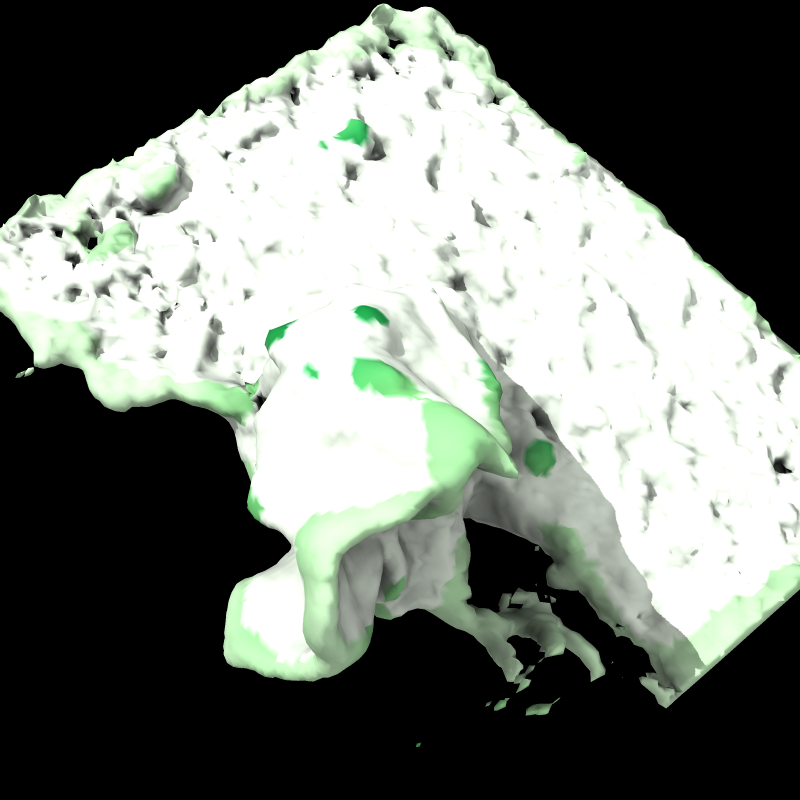